In [ ]:
!pip install torch torchvision transformers matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [21]:
# Load images from local paths and convert to RGB (if not already)
def load_and_process_image(image_path):
    img = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return img.resize((224, 224))  # Resize to 224x224

# Load and process both images
image_proper = load_and_process_image('/content/converse.png')
image_defective = load_and_process_image('/content/tornconverse.jpg')

# Preprocess images using the feature extractor
inputs_proper = feature_extractor(images=image_proper, return_tensors="pt")
inputs_defective = feature_extractor(images=image_defective, return_tensors="pt")


In [22]:
# Extract features from both images using ViT model
with torch.no_grad():  # Disable gradient calculation since we're just doing inference
    features_proper = model(**inputs_proper).last_hidden_state
    features_defective = model(**inputs_defective).last_hidden_state

# The features are in the form of a tensor; we can average over the sequence length (patches) to get a single vector for each image
features_proper_avg = features_proper.mean(dim=1).squeeze()  # Average over sequence length (patches)
features_defective_avg = features_defective.mean(dim=1).squeeze()  # Average over sequence length (patches)


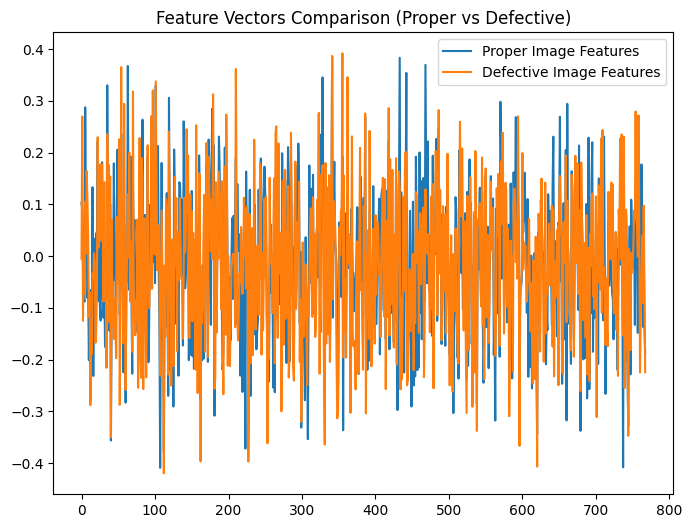

In [23]:
# Convert the feature vectors to numpy arrays for visualization or further processing
features_proper_np = features_proper_avg.cpu().numpy()
features_defective_np = features_defective_avg.cpu().numpy()

# Visualize the feature vectors (optional)
plt.figure(figsize=(8, 6))
plt.plot(features_proper_np, label="Proper Image Features")
plt.plot(features_defective_np, label="Defective Image Features")
plt.legend()
plt.title("Feature Vectors Comparison (Proper vs Defective)")
plt.show()


In [24]:
from scipy.spatial.distance import euclidean

# Calculate the Euclidean distance between the feature vectors of the proper and defective images
distance = euclidean(features_proper_avg.cpu().numpy(), features_defective_avg.cpu().numpy())

print(f"Euclidean distance between the proper and defective image features: {distance}")


Euclidean distance between the proper and defective image features: 3.3702213764190674


In [25]:
# Define the threshold value for defect detection
threshold = 10.0  # Adjust this value based on your experiments

# Calculate the Euclidean distance between the feature vectors
from scipy.spatial.distance import euclidean

distance = euclidean(features_proper_avg.cpu().numpy(), features_defective_avg.cpu().numpy())

# Display the comparison result
print(f"Euclidean distance between the proper and defective image features: {distance}")

# Classify based on the threshold
if distance < threshold:
    print("The images are similar (No defect detected).")
else:
    print("The images are different (Defect detected).")


Euclidean distance between the proper and defective image features: 3.3702213764190674
The images are similar (No defect detected).


In [26]:
# Extract features from deeper layers by specifying output_hidden_states=True
with torch.no_grad():
    outputs_proper = model(**inputs_proper, output_hidden_states=True)
    outputs_defective = model(**inputs_defective, output_hidden_states=True)

# Hidden states are stored in 'hidden_states' key of the outputs
hidden_states_proper = outputs_proper.hidden_states
hidden_states_defective = outputs_defective.hidden_states

# Use the second-to-last hidden layer's output, which might capture more localized features
features_proper_layer = hidden_states_proper[-2]  # Second to last hidden layer
features_defective_layer = hidden_states_defective[-2]  # Second to last hidden layer

# Average over the sequence length (patches) to get a fixed-size vector
features_proper_avg_layer = features_proper_layer.mean(dim=1).squeeze()
features_defective_avg_layer = features_defective_layer.mean(dim=1).squeeze()

# Compute the Euclidean distance on these refined features
distance_layer = euclidean(features_proper_avg_layer.cpu().numpy(), features_defective_avg_layer.cpu().numpy())
print(f"Euclidean distance between the deeper-layer features: {distance_layer}")


Euclidean distance between the deeper-layer features: 85.77808380126953


In [27]:
# Define a threshold for defect detection based on experimentation
threshold_layer = 15.0  # Adjust based on your observations

# Compare the distance with the threshold
if distance_layer < threshold_layer:
    print("The images are similar (No defect detected).")
else:
    print("The images are different (Defect detected).")


The images are different (Defect detected).


In [28]:
# Save the comparison result to a text file
with open("/content/comparison_result.txt", "w") as f:
    f.write(f"Euclidean distance: {distance_layer:.4f}\n")
    if distance_layer < threshold_layer:
        f.write("Result: The images are similar (No defect detected).\n")
    else:
        f.write("Result: The images are different (Defect detected).\n")


In [29]:
# Normalize Euclidean distance to a similarity score between 0 and 1
# You can experiment with different maximum values (max_distance) based on the scale of the dataset.

max_distance = 100.0  # This is an arbitrary max distance, can be adjusted based on the dataset

# Inverse similarity: Lower distance means higher similarity
similarity_score = 1 / (1 + (distance_layer / max_distance))  # Similarity score between 0 and 1

print(f"Similarity score: {similarity_score:.4f}")


Similarity score: 0.5383


In [30]:
if similarity_score > 0.8:  # High similarity means no defect detected
    print("The images are similar (No defect detected).")
else:  # Low similarity means defect detected
    print("The images are different (Defect detected).")


The images are different (Defect detected).


In [31]:
model.save_pretrained("/content/vit_model")
feature_extractor.save_pretrained("/content/vit_feature_extractor")

print("Model and feature extractor saved successfully.")


Model and feature extractor saved successfully.
